In [32]:
%matplotlib inline

from imports import *
#from scipy.stats.stats import pearsonr, spearmanr
#import itertools
np.set_printoptions(suppress=True)

In [33]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [41]:
source  = '/home/sobolev/nevermind/Andrey/data'
#source  = '/home/andrey/projects/data/'

sessions_PPC = [
    '008229_hippoSIT_2022-05-09_21-01-15',
    '008229_hippoSIT_2022-05-10_09-02-35',
    '008229_hippoSIT_2022-05-10_14-01-46',
    '008229_hippoSIT_2022-05-11_13-55-55',
    '008229_hippoSIT_2022-05-12_15-36-57',
    '008229_hippoSIT_2022-05-13_09-48-00',
    '008229_hippoSIT_2022-05-13_15-17-12',
    '008229_hippoSIT_2022-05-16_11-13-33',
    '008229_hippoSIT_2022-05-16_20-36-44',
    '008229_hippoSIT_2022-05-17_15-42-49',
    '008229_hippoSIT_2022-05-17_21-44-43',
    '008229_hippoSIT_2022-05-18_14-36-18',
    '008229_hippoSIT_2022-05-20_15-54-39',
    '008229_hippoSIT_2022-05-23_15-45-49',
    '008229_hippoSIT_2022-05-23_21-10-47',
]

sessions_HPC = [
    '008229_hippoSIT_2022-05-27_14-21-37',
    '008229_hippoSIT_2022-05-27_19-47-51',
    '008229_hippoSIT_2022-05-28_13-21-39',
    '008229_hippoSIT_2022-05-29_10-45-44',
    '008229_hippoSIT_2022-05-29_17-16-59',
    '008229_hippoSIT_2022-05-30_15-35-25',
    '008229_hippoSIT_2022-05-30_21-40-24',
    '008229_hippoSIT_2022-05-31_11-00-02',
    '008229_hippoSIT_2022-05-31_16-38-23',
    '008229_hippoSIT_2022-06-01_11-08-51',
    '008229_hippoSIT_2022-06-01_16-09-26',
    '008229_hippoSIT_2022-06-02_15-26-01',
    '008229_hippoSIT_2022-06-02_20-42-08',
    '008229_hippoSIT_2022-06-03_09-18-49',
]

sessions = sessions_HPC

## Performance depending on the position in the arena (allocentric)

In [42]:
tr_car, tr_pol, tr_btd = {}, {}, {}
names = ['succ_l', 'succ_d', 'fail_l', 'fail_d']
for name in names:
    tr_car[name], tr_pol[name], tr_btd[name] = [], [], []

succ_no = 0
for session in sessions:
    animal  = session.split('_')[0]
    sessionpath = os.path.join(source, animal, session)
    h5name  = os.path.join(source, animal, session, session + '.h5')

    with h5py.File(h5name, 'r') as f:
        tl = np.array(f['processed']['timeline'])  # time, X, Y, speed, etc.
        trials = np.array(f['processed']['trial_idxs'])  # t_start_idx, t_end_idx, x_tgt, y_tgt, r_tgt, result
        cfg = json.loads(f['processed'].attrs['parameters'])
    arena_r = float(cfg['position']['floor_r_in_meters'])
    timepoints = cfg['experiment']['timepoints']
    s_duration = cfg['experiment']['session_duration']
    
    l_periods = [[0, timepoints[0]], [timepoints[3], s_duration]]
    d_periods = [[timepoints[0], timepoints[3]]]
    
    # allocentric island positions - cartesian
    tr_succ = trials[trials[:, 5] == 1]
    tr_succ_l = tr_succ[(tl[tr_succ[:, 1].astype(np.int32)][:, 0] < l_periods[0][1]) | (tl[tr_succ[:, 1].astype(np.int32)][:, 0] > l_periods[1][0])][:, 2:4]
    tr_succ_d = tr_succ[(tl[tr_succ[:, 1].astype(np.int32)][:, 0] > d_periods[0][0]) & (tl[tr_succ[:, 1].astype(np.int32)][:, 0] < d_periods[0][1])][:, 2:4]

    tr_fail = trials[trials[:, 5] == 0]
    tr_fail_l = tr_fail[(tl[tr_fail[:, 1].astype(np.int32)][:, 0] < l_periods[0][1]) | (tl[tr_fail[:, 1].astype(np.int32)][:, 0] > l_periods[1][0])][:, 2:4]
    tr_fail_d = tr_fail[(tl[tr_fail[:, 1].astype(np.int32)][:, 0] > d_periods[0][0]) & (tl[tr_fail[:, 1].astype(np.int32)][:, 0] < d_periods[0][1])][:, 2:4]
    
    succ_no += len(tr_succ)
    assert(len(tr_succ) == len(tr_succ_l) + len(tr_succ_d))
    assert(len(tr_fail) == len(tr_fail_l) + len(tr_fail_d))
    assert(len(trials)  == len(tr_succ) + len(tr_fail))
    
    for name, data in zip(names, [tr_succ_l, tr_succ_d, tr_fail_l, tr_fail_d]):
        tr_car[name] = tr_car[name] + [data]
    
    # in polar
    for name, data in zip(names, [tr_succ_l, tr_succ_d, tr_fail_l, tr_fail_d]):
        in_pol = np.array([cart2pol(x[0], x[1]) for x in data])
        in_pol[:, 0] = in_pol[:, 0]**2
        tr_pol[name] = tr_pol[name] + [in_pol]    
    
    # distance to background / target (note error in speaker-moving conditions)
    phi_rot, bgr_phi, tgt_phi = cfg['experiment']['phi_max'], 90, 225
    
    bgr_pos_l = np.array([arena_r, np.deg2rad(bgr_phi)])   # in polar
    tgt_pos_l = np.array([arena_r, np.deg2rad(tgt_phi)])  # in polar
    bgr_pos_d = np.array([arena_r, np.deg2rad(bgr_phi)  - np.deg2rad(phi_rot)])   # in polar
    tgt_pos_d = np.array([arena_r, np.deg2rad(tgt_phi) - np.deg2rad(phi_rot)])  # in polar
    
    bgr_pos_l = pol2cart(*bgr_pos_l)
    tgt_pos_l = pol2cart(*tgt_pos_l)
    bgr_pos_d = pol2cart(*bgr_pos_d)
    tgt_pos_d = pol2cart(*tgt_pos_d)
    
    dists_bgr_succ_l = np.sqrt( (tr_succ_l[:, 0] - bgr_pos_l[0])**2 + (tr_succ_l[:, 1] - bgr_pos_l[1])**2 )
    dists_tgt_succ_l = np.sqrt( (tr_succ_l[:, 0] - tgt_pos_l[0])**2 + (tr_succ_l[:, 1] - tgt_pos_l[1])**2 )
    dists_bgr_fail_l = np.sqrt( (tr_fail_l[:, 0] - bgr_pos_l[0])**2 + (tr_fail_l[:, 1] - bgr_pos_l[1])**2 )
    dists_tgt_fail_l = np.sqrt( (tr_fail_l[:, 0] - tgt_pos_l[0])**2 + (tr_fail_l[:, 1] - tgt_pos_l[1])**2 )
    dists_bgr_succ_d = np.sqrt( (tr_succ_d[:, 0] - bgr_pos_d[0])**2 + (tr_succ_d[:, 1] - bgr_pos_d[1])**2 )
    dists_tgt_succ_d = np.sqrt( (tr_succ_d[:, 0] - tgt_pos_d[0])**2 + (tr_succ_d[:, 1] - tgt_pos_d[1])**2 )
    dists_bgr_fail_d = np.sqrt( (tr_fail_d[:, 0] - bgr_pos_d[0])**2 + (tr_fail_d[:, 1] - bgr_pos_d[1])**2 )
    dists_tgt_fail_d = np.sqrt( (tr_fail_d[:, 0] - tgt_pos_d[0])**2 + (tr_fail_d[:, 1] - tgt_pos_d[1])**2 )
    
    pos_succ_l = np.vstack([dists_bgr_succ_l, dists_tgt_succ_l]).T
    pos_succ_d = np.vstack([dists_bgr_succ_d, dists_tgt_succ_d]).T
    pos_fail_l = np.vstack([dists_bgr_fail_l, dists_tgt_fail_l]).T
    pos_fail_d = np.vstack([dists_bgr_fail_d, dists_tgt_fail_d]).T
    
    for name, data in zip(names, [pos_succ_l, pos_succ_d, pos_fail_l, pos_fail_d]):
        tr_btd[name] = tr_btd[name] + [data]  

    # TODO session by session
    
    # TODO angle between the sound sources from the animal

for name in names:
    tr_car[name] = np.concatenate(tr_car[name])
    tr_pol[name] = np.concatenate(tr_pol[name])
    tr_btd[name] = np.concatenate(tr_btd[name])

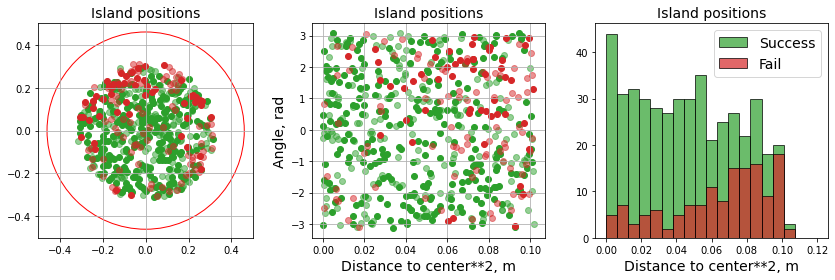

In [48]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

for i, to_plot in enumerate([tr_car, tr_pol]):
    axes[i].scatter(to_plot[names[0]][:, 0], to_plot[names[0]][:, 1], color=COLORS[2])
    axes[i].scatter(to_plot[names[1]][:, 0], to_plot[names[1]][:, 1], color=COLORS[2], alpha=0.5)
    axes[i].scatter(to_plot[names[2]][:, 0], to_plot[names[2]][:, 1], color=COLORS[3])
    axes[i].scatter(to_plot[names[3]][:, 0], to_plot[names[3]][:, 1], color=COLORS[3], alpha=0.5)
    
ax_alo_c = axes[0]
ax_alo_c.add_patch(plt.Circle((0, 0), arena_r, color='red', fill=False))
ax_alo_c.grid(b=True)
ax_alo_c.set_xlim(-0.5, 0.5)
ax_alo_c.set_ylim(-0.5, 0.5)
ax_alo_c.set_aspect('equal')
ax_alo_c.scatter([], [], color=COLORS[2], label='Success')
ax_alo_c.scatter([], [], color=COLORS[3], label='Fail')
#ax_alo_c.legend(fontsize=14, loc='upper left')
ax_alo_c.set_title('Island positions', fontsize=14)
    
ax_alo_p = axes[1]
#ax_alo_p.set_xlim(0, arena_r)
ax_alo_p.grid(b=True)
#ax_alo_p.set_aspect('equal')
ax_alo_p.set_xlabel('Distance to center**2, m', fontsize=14)
ax_alo_p.set_ylabel('Angle, rad', fontsize=14)
ax_alo_p.set_title('Island positions', fontsize=14)

ax = axes[2]
hst_succ = np.concatenate([tr_pol['succ_l'][:, 0], tr_pol['succ_d'][:, 0]])
hst_fail = np.concatenate([tr_pol['fail_l'][:, 0], tr_pol['fail_d'][:, 0]])
bins = np.linspace(0, 0.12, 20)
ax.hist(hst_succ, bins=bins, color=COLORS[2], alpha=0.7, edgecolor='k', label='Success')
ax.hist(hst_fail, bins=bins, color=COLORS[3], alpha=0.7, edgecolor='k', label='Fail')
ax.set_xlabel('Distance to center**2, m', fontsize=14)
ax.legend(fontsize=14, loc='upper right')
ax.set_title('Island positions', fontsize=14)

fig.tight_layout()

## Chances to hit the island depending on the distance to center

- Essentially this shows that animals learn the strategy to run close to the center (~0.1-0.2m) cause the chances to hit the island (relative to the distance run) are higher.
- Interesting to see if that affects hippocampal representation (border cells, bias to the center etc.)

In [44]:
collected = []
for session in sessions:
    animal  = session.split('_')[0]
    sessionpath = os.path.join(source, animal, session)
    h5name  = os.path.join(source, animal, session, session + '.h5')

    with h5py.File(h5name, 'r') as f:
        tl = np.array(f['processed']['timeline'])  # time, X, Y, speed, etc.
        trials = np.array(f['processed']['trial_idxs'])  # t_start_idx, t_end_idx, x_tgt, y_tgt, r_tgt, result
        cfg = json.loads(f['processed'].attrs['parameters'])
        
    # indices of all target entrances
    min_dur = 0  # min duration in target, sec
    idxs_target = np.where(tl[:, 6] == 2)[0]
    idxs_to_idx1 = np.where(np.diff(idxs_target) > 5)[0] + 1 # target starts
    idxs_to_idx2 = np.where(np.diff(idxs_target) > 5)[0][1:] # target ends
    idxs_to_idx  = np.where(idxs_to_idx2 - idxs_to_idx1[:-1] > min_dur * 100)[0]
    idxs_tgt_start = idxs_target[:-1][idxs_to_idx1[idxs_to_idx]]  # missing first entrance
    
    idxs_bgr_start = trials[:, 0].astype(np.int32)
    
    # add zeros / ones to separate
    idxs_bgr_start = np.vstack([idxs_bgr_start, np.zeros(len(idxs_bgr_start))]).T
    idxs_tgt_start = np.vstack([idxs_tgt_start, np.ones(len(idxs_tgt_start))]).T
    
    # 
    idxs = np.concatenate([idxs_bgr_start, idxs_tgt_start])
    idxs = idxs[idxs[:, 0].argsort()]
    
    idxs_first_tgt_hit = idxs[np.where(np.diff(idxs[:, 1]) > 0)[0] + 1][:, 0].astype(np.int32)
    dists = np.array([cart2pol(x[0], x[1]) for x in tl[idxs_first_tgt_hit][:, 1:3]])[:, 0]
    
    collected.append(dists)
    
dists = np.concatenate(collected)

(0.0, 0.46)

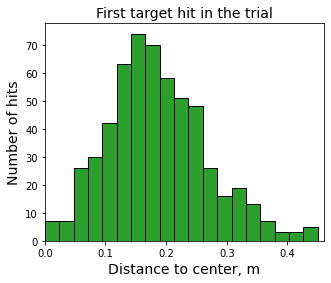

In [45]:
bins = np.linspace(0, 0.45, 20)

fig = plt.figure(figsize=(5, 4))

ax = fig.add_subplot(111)
ax.hist(dists, bins=bins, color=COLORS[2], edgecolor='k')
ax.set_xlabel('Distance to center, m', fontsize=14)
ax.set_ylabel('Number of hits', fontsize=14)
ax.set_title('First target hit in the trial', fontsize=14)
ax.set_xlim(0, 0.46)t

## Performance depending on position relative to the sound source

### NOTE: could be affected by proximity to the "entrance" wall. To test compare original and conflict conditions

In [46]:
dists_tgt_succ = np.concatenate([tr_btd['succ_l'][:, 1], tr_btd['succ_d'][:, 1]])
dists_tgt_fail = np.concatenate([tr_btd['fail_l'][:, 1], tr_btd['fail_d'][:, 1]])

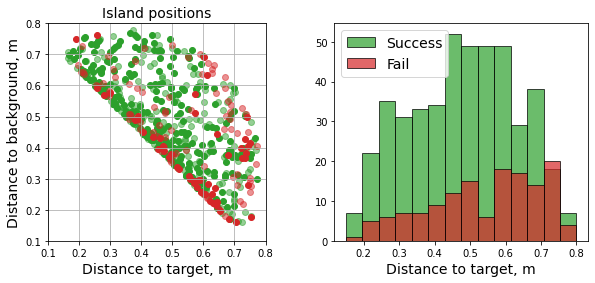

In [47]:
bins = np.linspace(0.15, 0.8, 15)

fig = plt.figure(figsize=(10, 4))

ax = fig.add_subplot(121)
ax.scatter(tr_btd[names[0]][:, 1], tr_btd[names[0]][:, 0], color=COLORS[2])
ax.scatter(tr_btd[names[1]][:, 1], tr_btd[names[1]][:, 0], color=COLORS[2], alpha=0.5)
ax.scatter(tr_btd[names[2]][:, 1], tr_btd[names[2]][:, 0], color=COLORS[3])
ax.scatter(tr_btd[names[3]][:, 1], tr_btd[names[3]][:, 0], color=COLORS[3], alpha=0.5)
ax.grid(b=True)
ax.set_aspect('equal')
ax.set_xlim(0.1, 0.8)
ax.set_ylim(0.1, 0.8)
ax.set_ylabel('Distance to background, m', fontsize=14)
ax.set_xlabel('Distance to target, m', fontsize=14)
ax.set_title('Island positions', fontsize=14)

ax = fig.add_subplot(122)
ax.hist(dists_tgt_succ, bins=bins, color=COLORS[2], alpha=0.7, edgecolor='k', label='Success')
ax.hist(dists_tgt_fail, bins=bins, color=COLORS[3], alpha=0.7, edgecolor='k', label='Fail')
ax.set_xlabel('Distance to target, m', fontsize=14)
ax.legend(fontsize=14, loc='upper left')

In [208]:
# position (angle) between target / background
# also chances to detect (stay) in the island depending on the position of the animal when it hits
# same but position + HD
# light vs dark?
# Performance in the active / passive listening state

# HYPOTHESIS  - in the middle animal is in the active listening state, closer to the walls - in passive state. WRONG
# HYPOTHESIS2 - it's easier to HIT the island by chance when it's in the middle rather when it's away. 
# so animal is developed "central" search behavior when "actively" engaged (listening)
# show active / passive occupancy as a proof


## Performance in the active / passive listening state